# --- Notebook : Modèle SVM - Cas de Tests de Régression ---

In [18]:
# --- Notebook : Modèle Linéaire - Cas de Tests de Régression ---
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [19]:
# === Chargement de la bibliothèque Rust compilée ===
lib = ctypes.CDLL("../target/release/mymodel.dll")

In [20]:
lib.train_and_predict_svm_rbf_multiclass.restype = ctypes.c_int
lib.train_and_predict_svm_rbf_multiclass.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # X (float64 *)
    ctypes.POINTER(ctypes.c_int),     # Y (int32 *)
    ctypes.c_size_t,                  # n_samples
    ctypes.c_size_t,                  # n_features
    ctypes.c_double,                  # gamma
    ctypes.c_double,                  # C
    ctypes.c_double,                  # lr
    ctypes.c_int,                    # epochs
    ctypes.POINTER(ctypes.c_double)  # x_vec (point à classer)
]


In [21]:
# === FFI declarations ===

lib.create_svm_rbf_classifier.argtypes = [
    ctypes.c_double,   # gamma
    ctypes.c_double,   # C
    ctypes.c_double,   # learning_rate
    ctypes.c_size_t    # epochs
]
lib.create_svm_rbf_classifier.restype = ctypes.c_void_p

lib.train_svm_rbf_classifier.argtypes = [
    ctypes.c_void_p,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),  # X_flat
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),  # Y
    ctypes.c_size_t,                                   # n_samples
    ctypes.c_size_t                                    # n_features
]

lib.predict_svm_rbf_classifier.argtypes = [
    ctypes.c_void_p,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),  # input vector
    ctypes.c_size_t                                    # n_features
]
lib.predict_svm_rbf_classifier.restype = ctypes.c_double


In [7]:
def run_svm_rbf_test(name, X, Y, lib, gamma=1.0, C=1.0, lr=0.01, epochs=1000):
    """
    Teste un classifieur SVM avec noyau RBF à partir de la bibliothèque Rust via FFI (sans n_support).
    """
    print(f"\n=== {name} ===")

    # Conversion des données
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)
    n_samples, n_features = X.shape
    X_flat = X.flatten()

    # Création du modèle
    model = lib.create_svm_rbf_classifier(gamma, C, lr, epochs)
    if not model:
        print(f"Erreur lors de la création du modèle SVM RBF pour {name}")
        return None

    # Entraînement
    lib.train_svm_rbf_classifier(model, X_flat, Y, n_samples, n_features)

    # Prédictions
    Y_pred = []
    for i in range(n_samples):
        x_input = X[i].astype(np.float64)
        pred = lib.predict_svm_rbf_classifier(model, x_input, n_features)
        Y_pred.append(int(pred))

    Y_pred = np.array(Y_pred)

    # Affichage des prédictions
    print("Exemples (prédiction vs vrai) :")
    for i in range(n_samples):
        print(f"  {X[i]} -> Prédit = {Y_pred[i]}, Vrai = {int(Y[i])}")

    return Y_pred


# Linear simple

In [8]:
def classif_test_linear_simple(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000):
    print("=== Classification Linéaire Simple avec SVM RBF ===")

    X = np.array([
        [1, 1], [2, 2], [3, 3],      # classe +1
        [1, 4], [2, 5], [3, 6]       # classe -1
    ], dtype=np.float64)

    Y = np.array([1, -1, 1, -1, 1, -1], dtype=np.float64)

    print("Données :")
    for i in range(len(X)):
        print(f"  {X[i]} -> {Y[i]}")

    # Prédictions
    Y_pred_rbf = run_svm_rbf_test("SVM RBF - Linear Simple", X, Y, lib, gamma, C, lr, epochs)

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', s=100, label='Classe +1')
    axes[0].scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', s=100, label='Classe -1')
    axes[0].set_title("Données originales")
    axes[0].legend()
    axes[0].grid(True)

    ax = axes[1]
    for i in range(len(X)):
        color = 'blue' if Y_pred_rbf[i] == 1 else 'red'
        marker = 'o' if Y_pred_rbf[i] == Y[i] else 'x'
        ax.scatter(X[i, 0], X[i, 1], color=color, s=100, marker=marker)
    ax.set_title("Prédictions - SVM RBF")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


=== Classification Linéaire Simple avec SVM RBF ===
Données :
  [1. 1.] -> 1.0
  [2. 2.] -> -1.0
  [3. 3.] -> 1.0
  [1. 4.] -> -1.0
  [2. 5.] -> 1.0
  [3. 6.] -> -1.0

=== SVM RBF - Linear Simple ===
Exemples (prédiction vs vrai) :
  [1. 1.] -> Prédit = 1, Vrai = 1
  [2. 2.] -> Prédit = -1, Vrai = -1
  [3. 3.] -> Prédit = 1, Vrai = 1
  [1. 4.] -> Prédit = -1, Vrai = -1
  [2. 5.] -> Prédit = 1, Vrai = 1
  [3. 6.] -> Prédit = -1, Vrai = -1


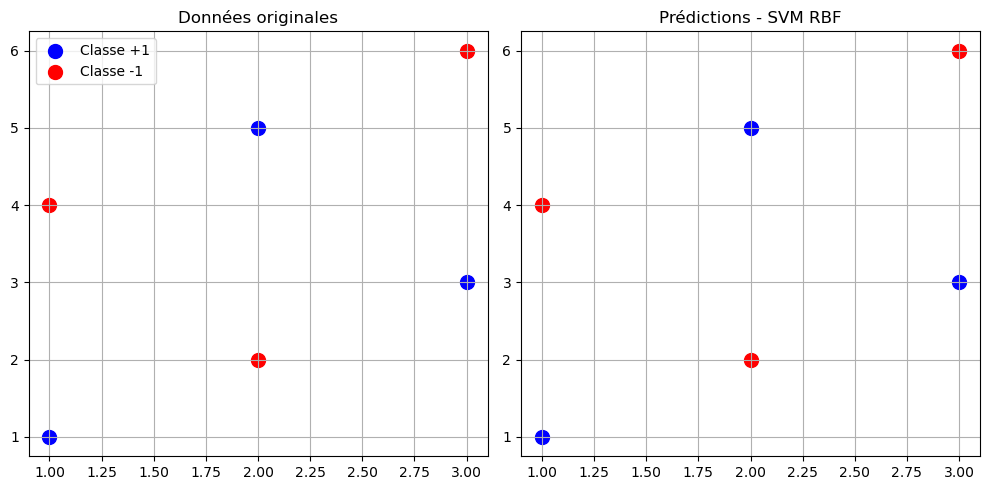

In [9]:
classif_test_linear_simple(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000)

# Linear Multiple

In [10]:
def classif_test_linear_multiple(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000):
    print("=== Classification Linéaire Multiple avec SVM RBF ===")

    X = np.array([
        [1, 1], [2, 2], [3, 3],
        [4, 4], [5, 5], [6, 6],
        [1, 6], [2, 7], [3, 8],
        [4, 9], [5, 10], [6, 11]
    ], dtype=np.float64)

    Y = np.array([1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1], dtype=np.float64)

    print("Données :")
    for i in range(len(X)):
        print(f"  {X[i]} -> {Y[i]}")

    # Prédictions
    Y_pred_rbf = run_svm_rbf_test("SVM RBF - Linear Multiple", X, Y, lib, gamma, C, lr, epochs)

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', s=100, label='Classe +1')
    axes[0].scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', s=100, label='Classe -1')
    axes[0].set_title("Données originales")
    axes[0].legend()
    axes[0].grid(True)

    ax = axes[1]
    for i in range(len(X)):
        color = 'blue' if Y_pred_rbf[i] == 1 else 'red'
        marker = 'o' if Y_pred_rbf[i] == Y[i] else 'x'
        ax.scatter(X[i, 0], X[i, 1], color=color, s=100, marker=marker)
    ax.set_title("Prédictions - SVM RBF")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


=== Classification Linéaire Multiple avec SVM RBF ===
Données :
  [1. 1.] -> 1.0
  [2. 2.] -> 1.0
  [3. 3.] -> 1.0
  [4. 4.] -> 1.0
  [5. 5.] -> 1.0
  [6. 6.] -> 1.0
  [1. 6.] -> -1.0
  [2. 7.] -> -1.0
  [3. 8.] -> -1.0
  [4. 9.] -> -1.0
  [ 5. 10.] -> -1.0
  [ 6. 11.] -> -1.0

=== SVM RBF - Linear Multiple ===
Exemples (prédiction vs vrai) :
  [1. 1.] -> Prédit = 1, Vrai = 1
  [2. 2.] -> Prédit = 1, Vrai = 1
  [3. 3.] -> Prédit = 1, Vrai = 1
  [4. 4.] -> Prédit = 1, Vrai = 1
  [5. 5.] -> Prédit = 1, Vrai = 1
  [6. 6.] -> Prédit = 1, Vrai = 1
  [1. 6.] -> Prédit = -1, Vrai = -1
  [2. 7.] -> Prédit = -1, Vrai = -1
  [3. 8.] -> Prédit = -1, Vrai = -1
  [4. 9.] -> Prédit = -1, Vrai = -1
  [ 5. 10.] -> Prédit = -1, Vrai = -1
  [ 6. 11.] -> Prédit = -1, Vrai = -1


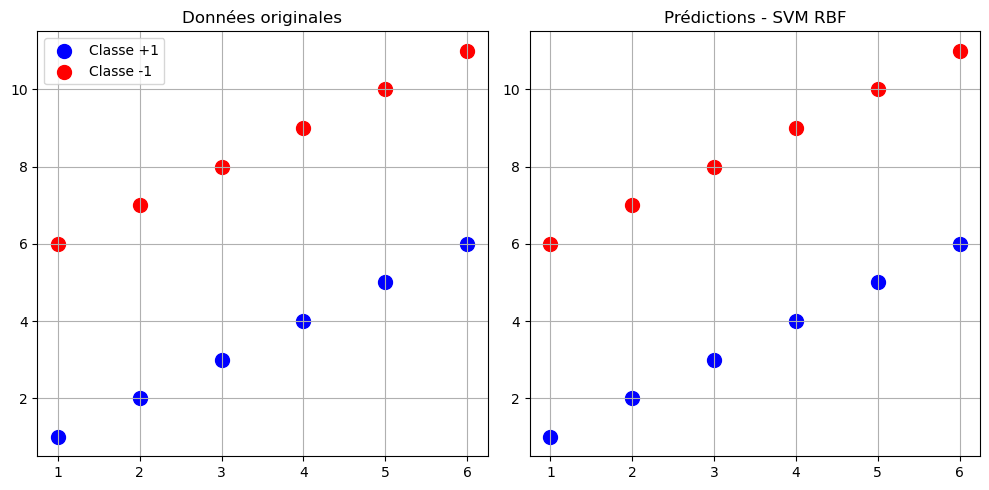

In [11]:
classif_test_linear_multiple(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000)

# XOR

In [12]:
def classif_test_3(lib, gamma=2.0, C=10.0, lr=0.05, epochs=2000):
    print("=== Classification XOR avec SVM RBF ===")

    X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype=np.float64)
    Y = np.array([1, 1, -1, -1], dtype=np.float64)

    print("Données XOR:")
    for i in range(len(X)):
        print(f"  {X[i]} -> {Y[i]}")

    # Appel avec les paramètres modifiables (sans n_support)
    Y_pred_rbf = run_svm_rbf_test("SVM RBF - XOR", X, Y, lib, gamma, C, lr, epochs)

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', s=100, label='Classe +1')
    axes[0].scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', s=100, label='Classe -1')
    axes[0].set_title("Données originales")
    axes[0].legend()
    axes[0].grid(True)

    ax = axes[1]
    for i in range(len(X)):
        color = 'blue' if Y_pred_rbf[i] == 1 else 'red'
        marker = 'o' if Y_pred_rbf[i] == Y[i] else 'x'
        ax.scatter(X[i, 0], X[i, 1], color=color, s=100, marker=marker)
    ax.set_title("Prédictions - SVM RBF")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


=== Classification XOR avec SVM RBF ===
Données XOR:
  [1. 0.] -> 1.0
  [0. 1.] -> 1.0
  [0. 0.] -> -1.0
  [1. 1.] -> -1.0

=== SVM RBF - XOR ===
Exemples (prédiction vs vrai) :
  [1. 0.] -> Prédit = 1, Vrai = 1
  [0. 1.] -> Prédit = 1, Vrai = 1
  [0. 0.] -> Prédit = -1, Vrai = -1
  [1. 1.] -> Prédit = -1, Vrai = -1


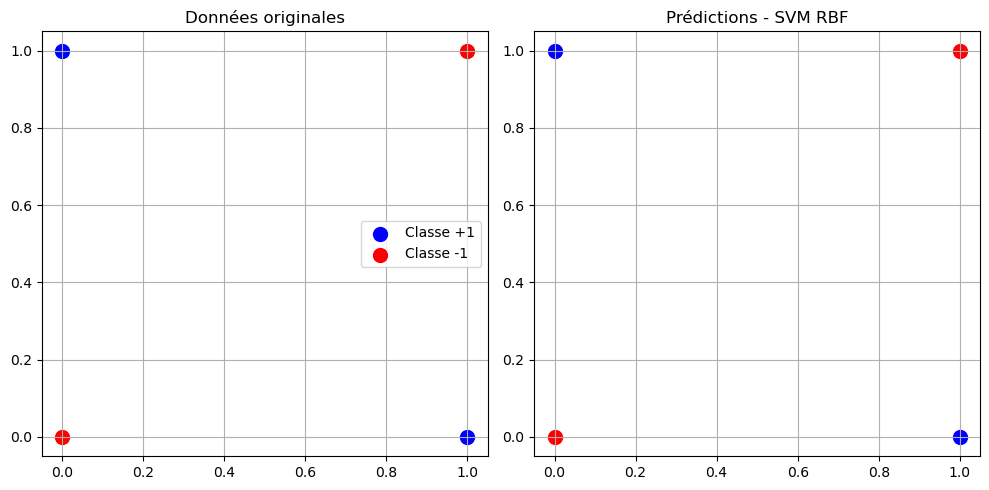

In [13]:
classif_test_3(lib, gamma=2.0, C=10.0, lr=0.05, epochs=2000)

#   Cross

In [14]:
def classif_test_cross(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000):
    print("=== Classification CROIX avec SVM RBF ===")

    X = np.array([
        [1, 0], [2, 0], [3, 0],
        [0, 1], [0, 2], [0, 3],
        [1, 1], [2, 2], [3, 3]
    ], dtype=np.float64)

    Y = np.array([1, 1, 1, 1, 1, 1, -1, -1, -1], dtype=np.float64)

    print("Données :")
    for i in range(len(X)):
        print(f"  {X[i]} -> {Y[i]}")

    Y_pred_rbf = run_svm_rbf_test("SVM RBF - Cross", X, Y, lib, gamma, C, lr, epochs)

    # Affichage graphique
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', s=100, label='Classe +1')
    axes[0].scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', s=100, label='Classe -1')
    axes[0].set_title("Données originales")
    axes[0].legend()
    axes[0].grid(True)

    ax = axes[1]
    for i in range(len(X)):
        color = 'blue' if Y_pred_rbf[i] == 1 else 'red'
        marker = 'o' if Y_pred_rbf[i] == Y[i] else 'x'
        ax.scatter(X[i, 0], X[i, 1], color=color, s=100, marker=marker)
    ax.set_title("Prédictions - SVM RBF")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


=== Classification CROIX avec SVM RBF ===
Données :
  [1. 0.] -> 1.0
  [2. 0.] -> 1.0
  [3. 0.] -> 1.0
  [0. 1.] -> 1.0
  [0. 2.] -> 1.0
  [0. 3.] -> 1.0
  [1. 1.] -> -1.0
  [2. 2.] -> -1.0
  [3. 3.] -> -1.0

=== SVM RBF - Cross ===
Exemples (prédiction vs vrai) :
  [1. 0.] -> Prédit = 1, Vrai = 1
  [2. 0.] -> Prédit = 1, Vrai = 1
  [3. 0.] -> Prédit = 1, Vrai = 1
  [0. 1.] -> Prédit = 1, Vrai = 1
  [0. 2.] -> Prédit = 1, Vrai = 1
  [0. 3.] -> Prédit = 1, Vrai = 1
  [1. 1.] -> Prédit = 1, Vrai = -1
  [2. 2.] -> Prédit = -1, Vrai = -1
  [3. 3.] -> Prédit = -1, Vrai = -1


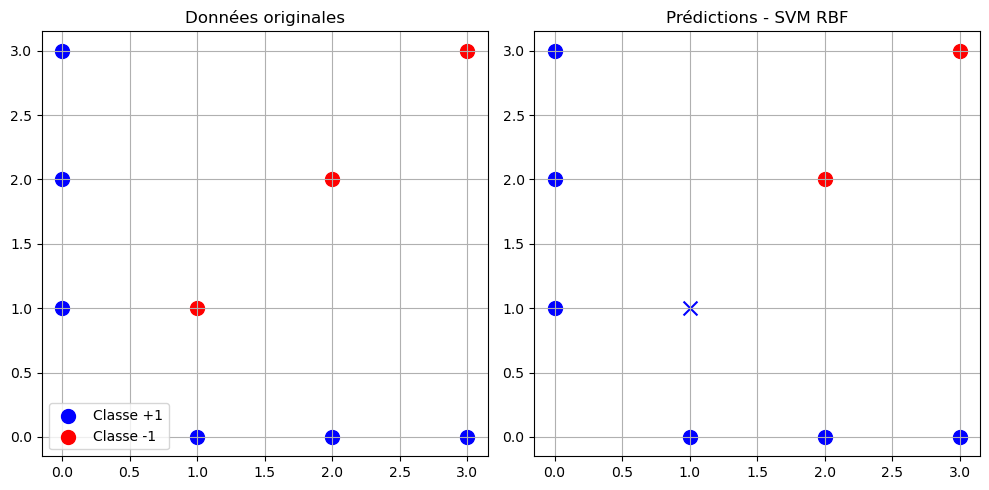

In [15]:
classif_test_cross(lib, gamma=1.0, C=1.0, lr=0.05, epochs=1000)

# --- Notebook : Modèle Linéaire - Cas de Tests de Classification avec SVM (binaire et multiclasses) ---


### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK
        

In [17]:
X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
], dtype=np.float64)

# Pour multiclass SVM, labels doive être des entiers
# Ici on adapte -1 → 0, 1 → 1
Y = np.array([1, 0, 0], dtype=np.uintp)  # classe 1 = 1, classe -1 = 0




# Création modèle
model_ptr = lib.create_svm_rbf_multiclass(
    ctypes.c_double(0.5),  # gamma
    ctypes.c_double(1.0),  # C
    ctypes.c_double(0.01), # learning rate
    ctypes.c_size_t(200)   # epochs
)

# Entraînement
lib.train_svm_rbf_multiclass(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t)),
    X.shape[0],
    X.shape[1]
)

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_svm_rbf_multiclass(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

print("Prédictions SVM multiclasses :")
for xi, yi in zip(X, Y):
    out = predict(xi)
    print(f"{xi.tolist()} → attendu : {int(yi)}, classe prédite : {int(out)}")

accuracy = (Y == np.array([predict(xi) for xi in X])).mean()
print(f"\nPrécision : {accuracy * 100:.2f}%")

# Tracé surface de décision
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(point) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Surface de décision SVM multiclasses RBF")
plt.show()
plt.clf()


OSError: exception: access violation reading 0x000000009D3DE9E0

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

Prédictions multiclasses :
[1.72001782 1.80736504] → classe prédite : 0, vraie : 0
[1.13905504 1.70226957] → classe prédite : 0, vraie : 0
[1.24876718 1.327348  ] → classe prédite : 0, vraie : 0
[1.71223013 1.17640804] → classe prédite : 0, vraie : 0
[1.82818359 1.17744585] → classe prédite : 0, vraie : 0
[1.58951594 1.66626553] → classe prédite : 0, vraie : 0
[1.53420521 1.51869814] → classe prédite : 0, vraie : 0
[1.46480509 1.58812237] → classe prédite : 0, vraie : 0
[1.09465465 1.51254437] → classe prédite : 0, vraie : 0
[1.795309   1.68214822] → classe prédite : 0, vraie : 0
[1.39231765 1.20132627] → classe prédite : 0, vraie : 0
[1.7604824 1.4289075] → classe prédite : 0, vraie : 0
[1.41519027 1.06123733] → classe prédite : 0, vraie : 0
[1.10741023 1.24572149] → classe prédite : 0, vraie : 0
[1.18679494 1.82187599] → classe prédite : 0, vraie : 0
[1.71775733 1.52417187] → classe prédite : 0, vraie : 0
[1.18955892 1.64773129] → classe prédite : 0, vraie : 0
[1.14244968 1.38744198]

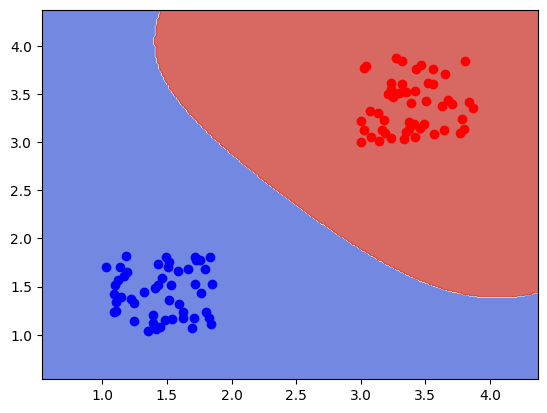

<Figure size 640x480 with 0 Axes>

In [12]:
X = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([3, 3])
]).astype(np.float64)

Y = np.concatenate([
    np.zeros((50,), dtype=np.uintp),
    np.ones((50,), dtype=np.uintp)
])

# Création modèle
model_ptr = lib.create_svm_rbf_multiclass(
    ctypes.c_double(0.5),  # gamma
    ctypes.c_double(1.0),  # C
    ctypes.c_double(0.01), # learning rate
    ctypes.c_size_t(200)   # epochs
)

# Entraînement
lib.train_svm_rbf_multiclass(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t)),
    X.shape[0],
    X.shape[1]
)

# Prédictions sur train
Y_pred = np.array([
    lib.predict_svm_rbf_multiclass(
        model_ptr,
        np.array(point, dtype=np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    ) for point in X
], dtype=np.uintp)

accuracy = (Y_pred == Y).sum() / len(Y) * 100

print("Prédictions multiclasses :")
for i in range(len(X)):
    print(f"{X[i]} → classe prédite : {Y_pred[i]}, vraie : {Y[i]}")
print(f"\nPrécision : {accuracy:.2f}%")

# Surface décision
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = np.array([
    lib.predict_svm_rbf_multiclass(
        model_ptr,
        np.array(point, dtype=np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    ) for point in grid
])

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[0:50, 0], X[0:50, 1], color="blue")
plt.scatter(X[50:100, 0], X[50:100, 1], color="red")
plt.show()
plt.clf()

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

[1.0, 0.0] => attendu: 1, prédit: 1 → classe 1
[0.0, 1.0] => attendu: 1, prédit: 1 → classe 1
[0.0, 0.0] => attendu: 0, prédit: 0 → classe 0
[1.0, 1.0] => attendu: 0, prédit: 0 → classe 0

Précision : 100.00% (4/4)


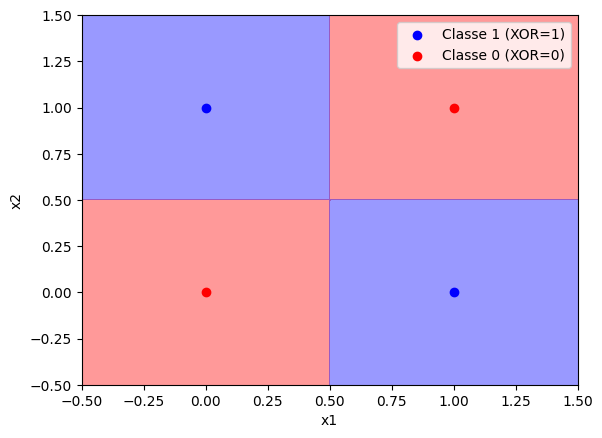

In [13]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype=np.float64)
Y = np.array([1, 1, 0, 0], dtype=np.uintp)  # Note : 0 et 1 pour classes (pas -1)

# Création modèle SVM multiclass
model_ptr = lib.create_svm_rbf_multiclass(
    ctypes.c_double(0.5),  # gamma
    ctypes.c_double(1.0),  # C
    ctypes.c_double(0.01), # learning rate
    ctypes.c_size_t(2000)  # epochs
)

# Entraînement
lib.train_svm_rbf_multiclass(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t)),
    X.shape[0],
    X.shape[1]
)

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_svm_rbf_multiclass(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

correct = 0
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe_pred = out
    print(f"{xi.tolist()} => attendu: {int(yi)}, prédit: {out} → classe {classe_pred}")
    if classe_pred == yi:
        correct += 1

accuracy = correct / len(Y) * 100
print(f"\nPrécision : {accuracy:.2f}% ({correct}/{len(Y)})")

x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(point) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, colors=["red", "blue"], levels=np.arange(-0.5, 2))
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color="blue", label="Classe 1 (XOR=1)")
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color="red", label="Classe 0 (XOR=0)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

x = [ 0.19084444 -0.56727792] → vrai = 1, prédit = 1
x = [0.5814769  0.78982894] → vrai = 0, prédit = 0
x = [-0.0830336  -0.21106099] → vrai = 1, prédit = 1
x = [0.43302331 0.7589948 ] → vrai = 0, prédit = 0
x = [-0.60919504  0.75519742] → vrai = 0, prédit = 0
x = [-0.26539811 -0.24326069] → vrai = 1, prédit = 1
x = [-0.684373   -0.35160425] → vrai = 0, prédit = 0
x = [-0.47816185  0.60972825] → vrai = 0, prédit = 0
x = [-0.89351197 -0.26381291] → vrai = 1, prédit = 1
x = [-0.5085433  -0.52649756] → vrai = 0, prédit = 0

Précision  : 98.60% 


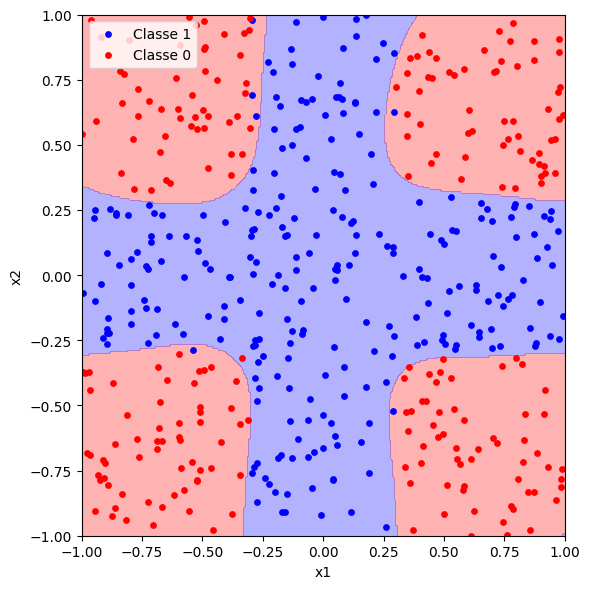

In [14]:

# Génération des données
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else 0 for p in X], dtype=np.uintp)


model_ptr = lib.create_svm_rbf_multiclass(
    ctypes.c_double(5.0),      
    ctypes.c_double(10.0),     
    ctypes.c_double(0.05),     
    ctypes.c_size_t(300)     
)

lib.train_svm_rbf_multiclass(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t)),
    X.shape[0],
    X.shape[1]
)

# Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_svm_rbf_multiclass(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

# Prédictions sur les données
Y_pred = np.array([predict(xi) for xi in X], dtype=np.uintp)

# Calcul de l'exactitude
accuracy = (Y_pred == Y).sum() / len(Y) * 100

# Affichage de quelques prédictions
for i in range(10):
    print(f"x = {X[i]} → vrai = {Y[i]}, prédit = {Y_pred[i]}")

print(f"\nPrécision  : {accuracy:.2f}% ")

# Visualisation de la frontière de décision
xx, yy = np.meshgrid(np.linspace(-1.0, 1.0, 300), np.linspace(-1.0, 1.0, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(p) for p in grid])
Z_classe = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z_classe, levels=[-0.5, 0.5, 1.5], colors=["red", "blue"], alpha=0.3)

# Scatter des vraies classes
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color="blue", s=15, label="Classe 1")
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color="red", s=15, label="Classe 0")

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()


### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

Accuracy: 98.00%


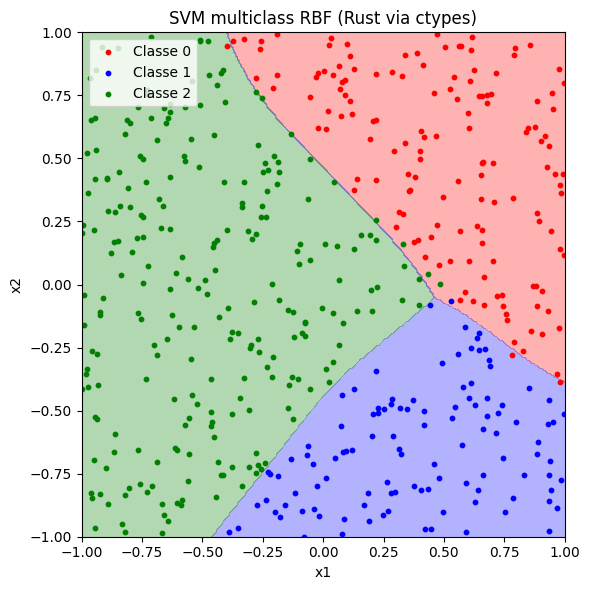

In [15]:


# === Données synthétiques ===
X = np.random.uniform(-1, 1, size=(500, 2)).astype(np.float64)
Y = np.array([
    0 if x[0] + x[1] > 0.5 else 1 if x[0] - x[1] > 0.5 else 2
    for x in X
], dtype=np.uintp) 

# === Paramètres SVM ===
gamma = 5.0
c = 1.0
lr = 0.1
epochs = 300
n_samples, n_features = X.shape

# === Création et entraînement du modèle ===
model = lib.create_svm_rbf_multiclass(gamma, c, lr, epochs)
lib.train_svm_rbf_multiclass(
    model,
    X.ctypes.data_as(c_double_p),
    Y.ctypes.data_as(c_usize_p),
    ctypes.c_size_t(n_samples),
    ctypes.c_size_t(n_features)
)

# === Fonction prédiction unitaire ===
def predict(x):
    return lib.predict_svm_rbf_multiclass(
        model,
        x.astype(np.float64).ctypes.data_as(c_double_p),
        ctypes.c_size_t(n_features)
    )

# === Évaluation sur les données d'entraînement ===
Y_pred = np.array([predict(x) for x in X], dtype=np.uintp)
accuracy = (Y_pred == Y).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# === Prédiction sur une grille pour affichage ===
xx, yy = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

# Prédictions manuelles 
Z = np.array([predict(x) for x in grid], dtype=np.uintp)
Z = Z.reshape(xx.shape)


# === Affichage graphique ===
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5, 2.5], colors=["red", "blue", "green"], alpha=0.3)

for i, color in enumerate(["red", "blue", "green"]):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=color, label=f"Classe {i}", s=10)

plt.legend()
plt.title("SVM multiclass RBF (Rust via ctypes)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()


### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK

x = [-0.71307507 -0.92717734], vrai = 1, prédit = 1
x = [0.1600871  0.24851018], vrai = 2, prédit = 2
x = [0.99396901 0.31987863], vrai = 2, prédit = 2
x = [ 0.22671907 -0.43129292], vrai = 2, prédit = 2
x = [-0.01013535  0.68520746], vrai = 1, prédit = 2
x = [0.13885316 0.72745142], vrai = 2, prédit = 2
x = [-0.20241588  0.26594999], vrai = 2, prédit = 2
x = [ 0.55616211 -0.75165562], vrai = 2, prédit = 2
x = [-0.53293261  0.85915498], vrai = 2, prédit = 2
x = [-0.60423343  0.12159794], vrai = 1, prédit = 1

Précision : 88.20%


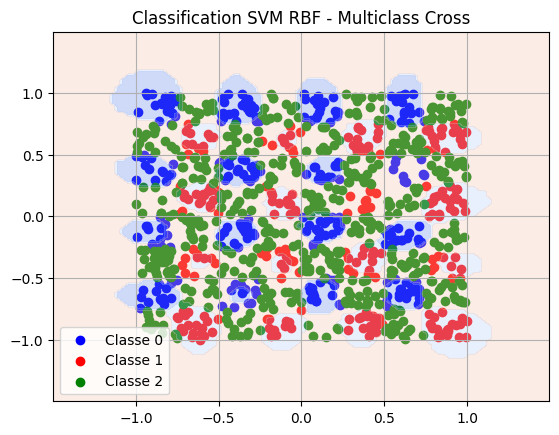

In [16]:
# === Données de type "croix" ===
X = np.random.random((1000, 2)) * 2.0 - 1.0

def cross_label(p):
    cond0 = abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25
    cond1 = abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25
    if cond0:
        return [1, 0, 0]
    elif cond1:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

Y = np.array([cross_label(p) for p in X])
Y_labels = np.argmax(Y, axis=1).astype(np.uintp)  

# === Paramètres SVM ===
gamma = 20.0
c = 1.0
lr = 0.1
epochs = 300
n_samples, n_features = X.shape
n_classes = 3

# === Création du modèle SVM multiclasses ===
model = ctypes.c_void_p(lib.create_svm_rbf_multiclass(gamma, c, lr, epochs))

# === Entraînement ===
lib.train_svm_rbf_multiclass(
    model,
    X.astype(np.float64).ctypes.data_as(c_double_p),
    Y_labels.ctypes.data_as(c_usize_p),
    ctypes.c_size_t(n_samples),
    ctypes.c_size_t(n_features)
)

# === Prédictions sur les données d'entraînement ===
def predict(point):
    return lib.predict_svm_rbf_multiclass(
        model,
        point.astype(np.float64).ctypes.data_as(c_double_p),
        ctypes.c_size_t(n_features)
    )

Y_pred = np.array([predict(x) for x in X], dtype=np.uintp)

# === Affichage des points ===
plt.scatter(X[Y[:, 0] == 1][:, 0], X[Y[:, 0] == 1][:, 1], color="blue", label="Classe 0")
plt.scatter(X[Y[:, 1] == 1][:, 0], X[Y[:, 1] == 1][:, 1], color="red", label="Classe 1")
plt.scatter(X[Y[:, 2] == 1][:, 0], X[Y[:, 2] == 1][:, 1], color="green", label="Classe 2")

# === Affichage des frontières de décision ===
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
)
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

Z = np.array([predict(pt) for pt in grid_points], dtype=np.uintp)
Z = Z.reshape(xx.shape)

# === Précision ===
correct = np.sum(Y_pred == Y_labels)
accuracy = correct * 100 / len(Y_labels)

for i in range(10):
    print(f"x = {X[i]}, vrai = {Y_labels[i]}, prédit = {Y_pred[i]}")

print(f"\nPrécision : {accuracy:.2f}%")

# === Plot final ===
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, n_classes + 1, 1), cmap="coolwarm")
plt.legend()
plt.title("Classification SVM RBF - Multiclass Cross")
plt.grid(True)
plt.show()